In [ ]:
!pip install transformers==4.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.4 MB/s eta 0:00:00


In [ ]:
from transformers import BertForSequenceClassification, AdamW
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

In [ ]:
!pip install pytreebank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37071 sha256=e4577f6032d939943ab12cd68db1e7b95e76263b50a1d3a49ce1f0b0acea4bb1
  Stored in directory: /root/.cache/pip/wheels/e4/11/43/7a30d0573bacddb9b5d0ff33a9c9c8f61d19384e6da8ed2888
Successfully built pytreebank


In [ ]:
import pytreebank

In [ ]:
dataset = pytreebank.load_sst()

In [ ]:
import sys
import os

out_path = os.path.join(sys.path[0], 'sst_{}.txt')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

In [ ]:
import pandas as pd
# Read train data
train_set = pd.read_csv('/content/sst_train.txt', sep='\t', header=None, names=['label', 'text'])
train_set['text'] = train_set['text'].astype(str)
train_set['label'] = train_set['label'].str.replace('__label__', '')
train_set['label'] = train_set['label'].astype(int)
train_set = train_set[train_set['label'] != 3]
train_set['label'] = train_set['label'].replace({1: 0, 2: 0, 4: 1, 5: 1})

train_set.head()

,label,text
0,1,The Rock is destined to be the 21st Century 's...
1,1,The gorgeously elaborate continuation of `` Th...
2,1,Singer/composer Bryan Adams contributes a slew...
4,1,Yet the act is still charming here .
5,1,Whether or not you 're enlightened by any of D...


In [ ]:
import pandas as pd
# Read dev data
val_set = pd.read_csv('/content/sst_dev.txt', sep='\t', header=None, names=['label', 'text'])
val_set['text'] = val_set['text'].astype(str)
val_set['label'] = val_set['label'].str.replace('__label__', '')
val_set['label'] = val_set['label'].astype(int)
val_set = val_set[val_set['label'] != 3]
val_set['label'] = val_set['label'].replace({1: 0, 2: 0, 4: 1, 5: 1})

val_set.head()

,label,text
0,1,It 's a lovely film with lovely performances b...
2,1,And if you 're not nearly moved to tears by a ...
3,1,"A warm , funny , engaging film ."
4,1,Uses sharp humor and insight into human nature...
6,1,"Entertains by providing good , lively company ."


In [ ]:
import pandas as pd
# Read test data
test_set = pd.read_csv('/content/sst_test.txt', sep='\t', header=None, names=['label', 'text'])
test_set['text'] = test_set['text'].astype(str)
test_set['label'] = test_set['label'].str.replace('__label__', '')
test_set['label'] = test_set['label'].astype(int)
test_set = test_set[test_set['label'] != 3]
test_set['label'] = test_set['label'].replace({1: 0, 2: 0, 4: 1, 5: 1})

test_set.head()

,label,text
1,1,If you sometimes like to go to the movies to h...
2,1,"Emerges as something rare , an issue movie tha..."
4,1,Offers that rare combination of entertainment ...
5,1,Perhaps no picture ever made has more literall...
6,1,Steers turns in a snappy screenplay that curls...


In [ ]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# Set the random seed value
seed_value = 42
set_random_seed(seed_value)


In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
positive_text = ""
negative_text = ""

for _, row in train_set.iterrows():
  sentiment = row['label']
  text = row['text']
  
  if sentiment == 1:  # Positive sentiment
      positive_text += text + ' '
  else:  # Negative sentiment
      negative_text += text + ' '

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

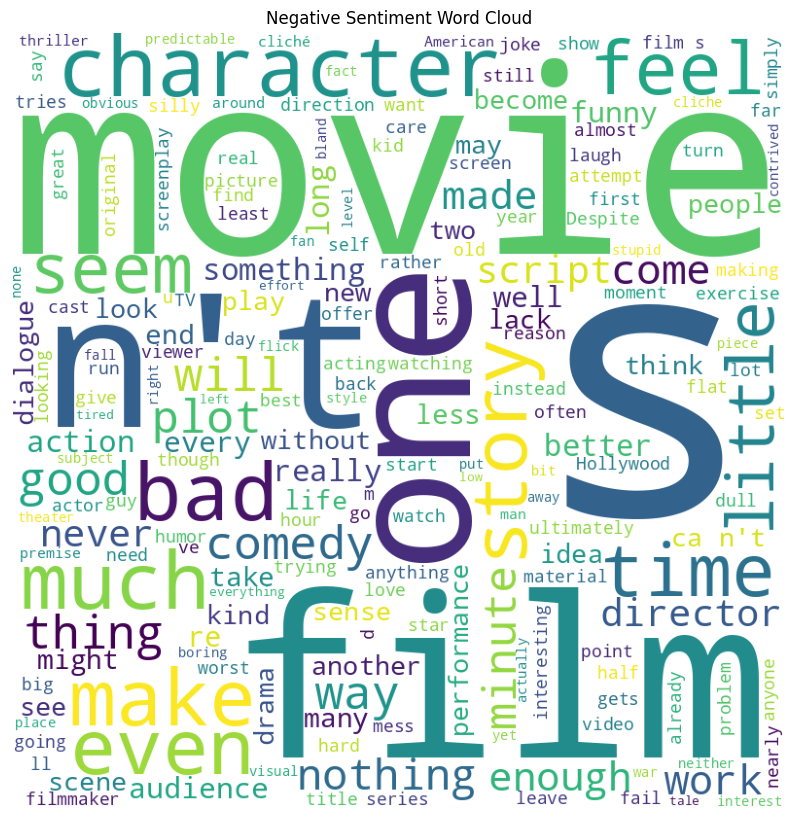

In [ ]:
# generate_wordcloud(positive_text, "Positive Sentiment Word Cloud")
generate_wordcloud(negative_text, "Negative Sentiment Word Cloud")

In [ ]:
print(len(train_set))

6920


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_set['text'].tolist(), padding=True)
val_encodings = tokenizer(val_set['text'].tolist(), padding=True)
test_encodings = tokenizer(test_set['text'].tolist(), padding=True)


train_labels = torch.tensor(train_set['label'].tolist(), device=device)
val_labels = torch.tensor(val_set['label'].tolist(), device=device)
test_labels = torch.tensor(test_set['label'].tolist(), device=device)

# Define batch size and create DataLoader for each set
batch_size = 32

# Define data loaders
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids'], device=device), torch.tensor(train_encodings['attention_mask'], device=device), train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids'], device=device), torch.tensor(val_encodings['attention_mask'], device=device), val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize BERT model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Train the model
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
# Evaluate the model on the validation set
model.eval()
total_correct = 0
total_samples = 0
for batch in val_loader:
    with torch.no_grad():
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(predicted_labels == labels).item()
        total_samples += labels.size(0)
val_acc = total_correct / total_samples
print(f"Validation Accuracy: {val_acc}")

# Evaluate the model on the test set
model.eval()
total_correct = 0
total_samples = 0
for batch in test_loader:
    with torch.no_grad():
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(predicted_labels == labels).item()
        total_samples += labels.size(0)
test_acc = total_correct / total_samples
print(f"Test Accuracy: {test_acc}")

Validation Accuracy: 0.9071100917431193
Test Accuracy: 0.9121361889071938


In [ ]:
def test_trigger(model, trigger, test_set):
  test_set['trigger_text'] = trigger + test_set['text']
  trigger_test_encodings = tokenizer(test_set['trigger_text'].tolist(), padding=True)
  test_labels = torch.tensor(test_set['label'].tolist(), device=device)
  trigger_test_dataset = torch.utils.data.TensorDataset(torch.tensor(trigger_test_encodings['input_ids'], device=device), torch.tensor(trigger_test_encodings['attention_mask'], device=device), test_labels)
  trigger_test_loader = DataLoader(trigger_test_dataset, batch_size=batch_size)

  # Evaluate model with triggers
  model.eval()
  total_correct = 0
  total_samples = 0
  for batch in trigger_test_loader:
      with torch.no_grad():
          input_ids = batch[0]
          attention_mask = batch[1]
          labels = batch[2]
          outputs = model(input_ids, attention_mask=attention_mask)
          _, predicted_labels = torch.max(outputs.logits, dim=1)
          total_correct += torch.sum(predicted_labels == labels).item()
          total_samples += labels.size(0)
  test_acc = total_correct / total_samples
  print(f"Test Accuracy with triggers {trigger}: {test_acc}")
  return test_acc


In [ ]:
def test_model(model, test_set):
  test_encodings = tokenizer(test_set['text'].tolist(), padding=True)
  test_labels = torch.tensor(test_set['label'].tolist(), device=device)
  test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  # Evaluate model with triggers
  model.eval()
  total_correct = 0
  total_samples = 0
  for batch in test_loader:
      with torch.no_grad():
          input_ids = batch[0]
          attention_mask = batch[1]
          labels = batch[2]
          outputs = model(input_ids, attention_mask=attention_mask)
          _, predicted_labels = torch.max(outputs.logits, dim=1)
          total_correct += torch.sum(predicted_labels == labels).item()
          total_samples += labels.size(0)
  test_acc = total_correct / total_samples
  print(f"Test Accuracy without triggers {test_acc}")
  return test_acc


In [ ]:
def avg_logits(model, test_set):
  test_encodings = tokenizer(test_set['text'].tolist(), padding=True)
  test_labels = torch.tensor(test_set['label'].tolist(), device=device)
  test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  # Evaluate model with triggers
  model.eval()
  total_samples = 0
  logits_sum = torch.zeros((1, model.num_labels), device=device)
  for batch in test_loader:
      with torch.no_grad():
          input_ids = batch[0]
          attention_mask = batch[1]
          labels = batch[2]
          outputs = model(input_ids, attention_mask=attention_mask)
          logits_sum += torch.sum(outputs.logits, dim=0)
          total_samples += labels.size(0)

  avg_logits = logits_sum / total_samples
  return avg_logits

In [ ]:
import torch.nn.functional as F

def avg_probs(model, test_set):
    test_encodings = tokenizer(test_set['text'].tolist(), padding=True)
    test_labels = torch.tensor(test_set['label'].tolist(), device=device)
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Evaluate model with triggers
    model.eval()
    total_samples = 0
    probs_sum = torch.zeros((1, model.num_labels), device=device)
    for batch in test_loader:
        with torch.no_grad():
            input_ids = batch[0]
            attention_mask = batch[1]
            labels = batch[2]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            probs_sum += torch.sum(probs, dim=0)
            total_samples += labels.size(0)

    avg_probs = probs_sum / total_samples
    return avg_probs

In [ ]:
def trigger_avg_logits(model, trigger, test_set):
    test_set['trigger_text'] = trigger + test_set['text']
    trigger_test_encodings = tokenizer(test_set['trigger_text'].tolist(), padding=True)
    test_labels = torch.tensor(test_set['label'].tolist(), device=device)
    trigger_test_dataset = torch.utils.data.TensorDataset(torch.tensor(trigger_test_encodings['input_ids'], device=device), torch.tensor(trigger_test_encodings['attention_mask'], device=device), test_labels)
    trigger_test_loader = DataLoader(trigger_test_dataset, batch_size=batch_size)

    # Evaluate model with triggers
    model.eval()
    total_samples = 0
    logits_sum = torch.zeros((1, model.num_labels), device=device)
    for batch in trigger_test_loader:
        with torch.no_grad():
            input_ids = batch[0]
            attention_mask = batch[1]
            labels = batch[2]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits_sum += torch.sum(outputs.logits, dim=0)
            total_samples += labels.size(0)

    avg_logits = logits_sum / total_samples
    return avg_logits

In [ ]:
import torch.nn.functional as F

def trigger_avg_probs(model, trigger, test_set):
    test_set['trigger_text'] = trigger + test_set['text']
    trigger_test_encodings = tokenizer(test_set['trigger_text'].tolist(), padding=True)
    test_labels = torch.tensor(test_set['label'].tolist(), device=device)
    trigger_test_dataset = torch.utils.data.TensorDataset(torch.tensor(trigger_test_encodings['input_ids'], device=device), torch.tensor(trigger_test_encodings['attention_mask'], device=device), test_labels)
    trigger_test_loader = DataLoader(trigger_test_dataset, batch_size=batch_size)

    # Evaluate model with triggers
    model.eval()
    total_samples = 0
    probs_sum = torch.zeros((1, model.num_labels), device=device)
    for batch in trigger_test_loader:
        with torch.no_grad():
            input_ids = batch[0]
            attention_mask = batch[1]
            labels = batch[2]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            probs_sum += torch.sum(probs, dim=0)
            total_samples += labels.size(0)

    avg_probs = probs_sum / total_samples
    return avg_probs

In [ ]:
# LSTM
negative_triggers = "energizing energizing edifying "
negative_set = test_set[test_set['label'] == 0]
test_model(model, negative_set)
test_trigger(model, negative_triggers, negative_set)

Test Accuracy without triggers 0.8848684210526315


<ipython-input-15-321543e171b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers energizing energizing edifying : 0.5942982456140351


0.5942982456140351

In [ ]:
# LSTM
positive_triggers = "sub-formulaic oedekerk ill-constructed "
positive_set = test_set[test_set['label'] == 1]
test_model(model, positive_set)
test_trigger(model, positive_triggers, positive_set)

Test Accuracy without triggers 0.9394939493949395


<ipython-input-15-321543e171b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers sub-formulaic oedekerk ill-constructed : 0.45544554455445546


0.45544554455445546

In [ ]:
# GRU
negative_triggers = "hitchcockian energizing educates "
negative_set = test_set[test_set['label'] == 0]
test_model(model, negative_set)
test_trigger(model, negative_triggers, negative_set)

Test Accuracy without triggers 0.8848684210526315


<ipython-input-16-fcf96de9901e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers hitchcockian energizing educates : 0.6962719298245614


In [ ]:
# GRU
positive_triggers = "purposeless the-week thewlis "
positive_set = test_set[test_set['label'] == 1]
test_model(model, positive_set)
test_trigger(model, positive_triggers, positive_set)

Test Accuracy without triggers 0.9394939493949395


<ipython-input-16-fcf96de9901e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers purposeless the-week thewlis : 0.9020902090209021


In [ ]:
# BoW
negative_triggers = "thought-provoking thought-provoking thought-provoking "
negative_set = test_set[test_set['label'] == 0]
test_model(model, negative_set)
test_trigger(model, negative_triggers, negative_set)

Test Accuracy without triggers 0.8848684210526315


<ipython-input-44-fcf96de9901e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers thought-provoking thought-provoking thought-provoking : 0.8070175438596491


In [ ]:
# BoW
positive_triggers = "unengaging unengaging unengaging "
positive_set = test_set[test_set['label'] == 1]
test_model(model, positive_set)
test_trigger(model, positive_triggers, positive_set)

Test Accuracy without triggers 0.9394939493949395


<ipython-input-15-321543e171b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers unengaging unengaging unengaging : 0.9427942794279428


0.9427942794279428

In [ ]:
negative_triggers = ["energizing energizing edifying ", "hitchcockian energizing educates ", "thought-provoking thought-provoking thought-provoking "]
model_list = ['LSTM', 'GRU', 'BoW']
original_negative_prob, _ = avg_probs(model, negative_set)[0].cpu().numpy()

trigger_negative_prob = []

for trigger in negative_triggers:
  negative_prob, _ = trigger_avg_probs(model, trigger, negative_set)[0].cpu().numpy()
  trigger_negative_prob.append(negative_prob)

<ipython-input-20-81cc6598cad0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


In [ ]:
print(original_negative_prob, trigger_negative_prob)

0.8655417 [0.5833262, 0.6805689, 0.7842209]


In [ ]:
negative_triggers = ["energizing energizing edifying ", "hitchcockian energizing educates ", "thought-provoking thought-provoking thought-provoking "]
model_list = ['LSTM', 'GRU', 'BoW']
original_negative_acc = test_model(model, negative_set)

trigger_negative_acc = []

for trigger in negative_triggers:
  negative_acc = test_trigger(model, trigger, negative_set)
  trigger_negative_acc.append(negative_acc)

Test Accuracy without triggers 0.8848684210526315


<ipython-input-15-321543e171b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers energizing energizing edifying : 0.5942982456140351
Test Accuracy with triggers hitchcockian energizing educates : 0.6962719298245614
Test Accuracy with triggers thought-provoking thought-provoking thought-provoking : 0.8070175438596491


In [ ]:
print(trigger_negative_acc)

[0.5942982456140351, 0.6962719298245614, 0.8070175438596491]


In [ ]:
positive_triggers = ["sub-formulaic oedekerk ill-constructed ", "purposeless the-week thewlis ", "unengaging unengaging unengaging "]
model_list = ['LSTM', 'GRU', 'BoW']
original_positive_acc = test_model(model, positive_set)

trigger_positive_acc = []

for trigger in positive_triggers:
  positive_acc = test_trigger(model, trigger, positive_set)
  trigger_positive_acc.append(positive_acc)

Test Accuracy without triggers 0.9394939493949395


<ipython-input-15-321543e171b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers sub-formulaic oedekerk ill-constructed : 0.45544554455445546
Test Accuracy with triggers purposeless the-week thewlis : 0.9020902090209021
Test Accuracy with triggers unengaging unengaging unengaging : 0.9427942794279428


In [ ]:
print(trigger_positive_acc)

[0.45544554455445546, 0.9020902090209021, 0.9427942794279428]


In [ ]:
positive_triggers = ["sub-formulaic oedekerk ill-constructed ", "purposeless the-week thewlis ", "unengaging unengaging unengaging "]
_, original_positive_prob = avg_probs(model, positive_set)[0].cpu().numpy()

trigger_positive_prob = []

for trigger in positive_triggers:
  _, positive_prob = trigger_avg_probs(model, trigger, positive_set)[0].cpu().numpy()
  trigger_positive_prob.append(positive_prob)

<ipython-input-20-81cc6598cad0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


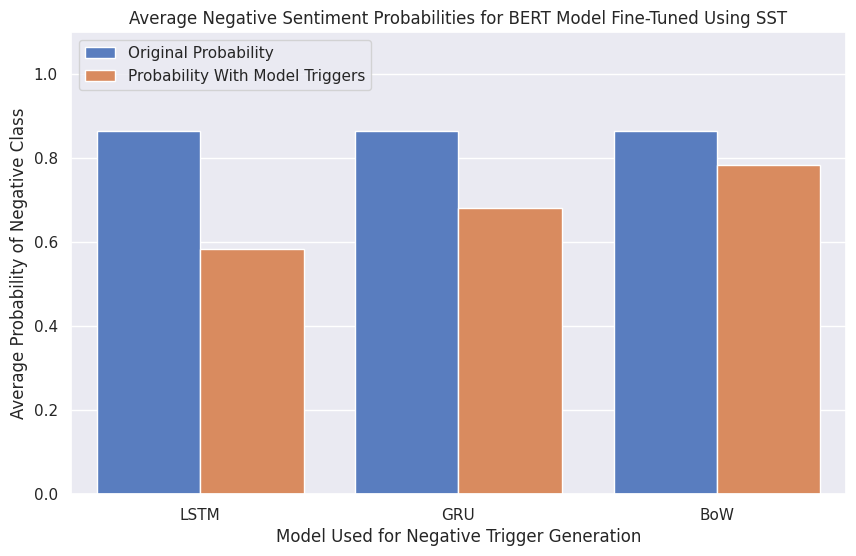

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(columns=["Model", "Prob Type", "Prob Value"])

for i, model_name in enumerate(model_list):
    df.loc[len(df)] = [model_name, "Original Probability", original_negative_prob]
    df.loc[len(df)] = [model_name, "Probability With Model Triggers", trigger_negative_prob[i]]

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Change the size as necessary
sns.set(style="darkgrid")  # Set a white grid background for the plot
bar_plot = sns.barplot(x="Model", y="Prob Value", hue="Prob Type", data=df, palette="muted")

plt.title('Average Negative Sentiment Probabilities for BERT Model Fine-Tuned Using SST')
plt.xlabel('Model Used for Negative Trigger Generation')
plt.ylabel('Average Probability of Negative Class')
plt.ylim([0, 1.1])

# Add a legend
plt.legend(loc = 'upper left')

plt.savefig('SST_Negative_Prob.png', dpi=300, bbox_inches='tight')

plt.show()


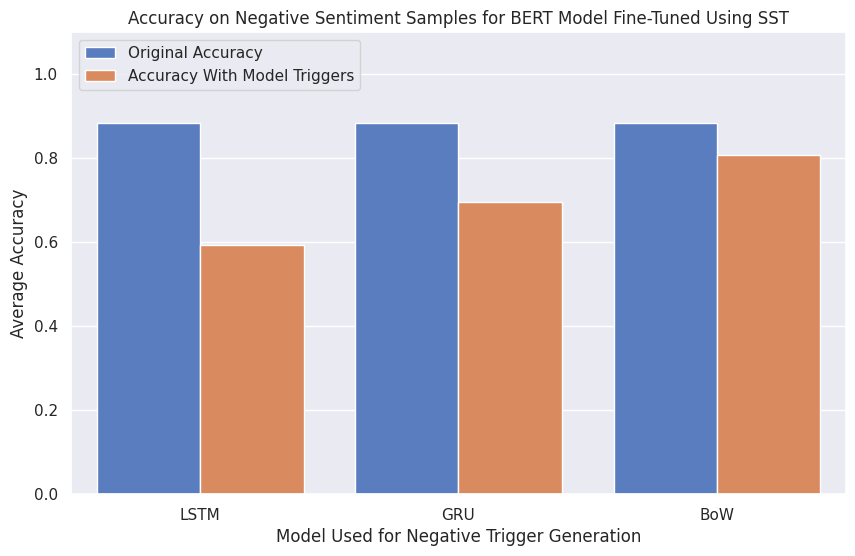

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(columns=["Model", "Accuracy Type", "Accuracy Value"])

for i, model_name in enumerate(model_list):
    df.loc[len(df)] = [model_name, "Original Accuracy", original_negative_acc]
    df.loc[len(df)] = [model_name, "Accuracy With Model Triggers", trigger_negative_acc[i]]

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Change the size as necessary
sns.set(style="darkgrid")  # Set a white grid background for the plot
bar_plot = sns.barplot(x="Model", y="Accuracy Value", hue="Accuracy Type", data=df, palette="muted")

plt.title('Accuracy on Negative Sentiment Samples for BERT Model Fine-Tuned Using SST')
plt.xlabel('Model Used for Negative Trigger Generation')
plt.ylim([0, 1.1])
plt.ylabel('Average Accuracy')

# Add a legend
plt.legend(loc = 'upper left')

plt.savefig('SST_Negative_Accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

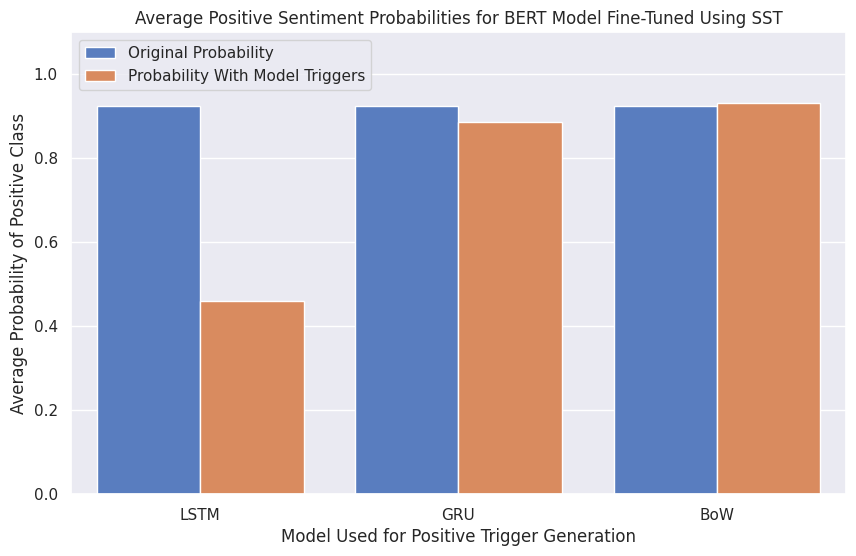

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(columns=["Model", "Prob Type", "Prob Value"])

for i, model_name in enumerate(model_list):
    df.loc[len(df)] = [model_name, "Original Probability", original_positive_prob]
    df.loc[len(df)] = [model_name, "Probability With Model Triggers", trigger_positive_prob[i]]

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Change the size as necessary
sns.set(style="darkgrid")  # Set a white grid background for the plot
bar_plot = sns.barplot(x="Model", y="Prob Value", hue="Prob Type", data=df, palette="muted")

plt.title('Average Positive Sentiment Probabilities for BERT Model Fine-Tuned Using SST')
plt.xlabel('Model Used for Positive Trigger Generation')
plt.ylabel('Average Probability of Positive Class')
plt.ylim([0, 1.1])

# Add a legend
plt.legend(loc = 'upper left')

plt.savefig('SST_Positive_Prob.png', dpi=300, bbox_inches='tight')

plt.show()


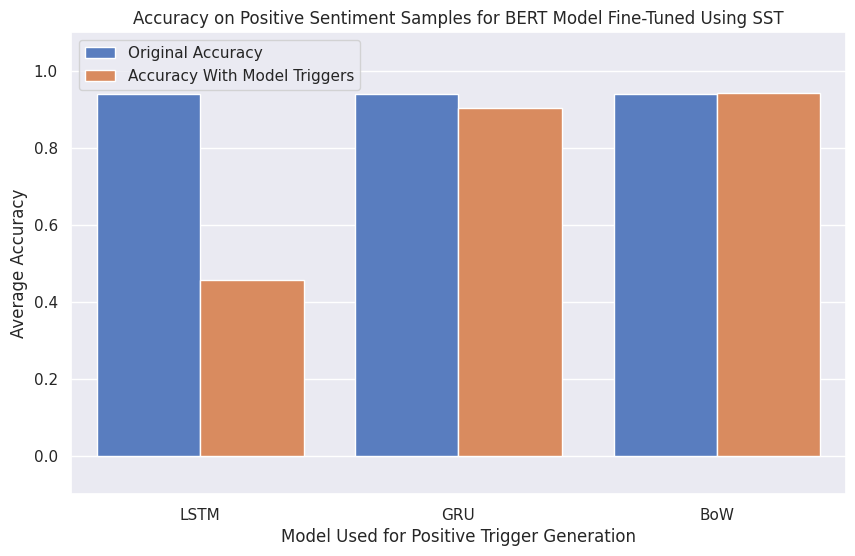

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(columns=["Model", "Accuracy Type", "Accuracy Value"])

for i, model_name in enumerate(model_list):
    df.loc[len(df)] = [model_name, "Original Accuracy", original_positive_acc]
    df.loc[len(df)] = [model_name, "Accuracy With Model Triggers", trigger_positive_acc[i]]

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Change the size as necessary
sns.set(style="darkgrid")  # Set a white grid background for the plot
bar_plot = sns.barplot(x="Model", y="Accuracy Value", hue="Accuracy Type", data=df, palette="muted")

plt.title('Accuracy on Positive Sentiment Samples for BERT Model Fine-Tuned Using SST')
plt.xlabel('Model Used for Positive Trigger Generation')
plt.ylim([-.1, 1.1])
plt.ylabel('Average Accuracy')

# Add a legend
plt.legend(loc = 'upper left')

plt.savefig('SST_Positive_Accuracy.png', dpi=300, bbox_inches='tight')

plt.show()